# Biodiversity Intactness Index change in Phoenix, AZ
### Author: Bailey Jørgensen
**Repository:** https://github.com/jorb1/eds220-BII

## About:

**Purpose:**
In 2021, Maricopa County —home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001. This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems.

In this notebook, I will investigate the impacts of urban expansion by analyzing a dataset that captures values for the Biodiversity Intactness Index (BII). Apecifically, I will examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.

**Highlights:**
1. Accessing the Microsoft Planetary Computer to Access their Impact Observatory data.

2. Creating a plot of the Biodiversity Intactness Index within the Phoenix subdivision polygon.

3. Calculate the percentage of area of the Phoenix area with a BII index of at least .07 in 2017 and 2020.

4. Plotting the 2020 data, revealing areas that show a loss of biodiversity.

**About the data:**
1. The first data set is is the Biodiversity Intactness Index (BII) Time Series. Access the io-biodiversity collection from the Microsoft Planetary Computer STAC catalog. I will be using the 2017 and 2020 rasters covering the Phoenix subdivision. 

2. The second data set is the Phoenix Subdivision Shapefile Download the Phoenix subdivision polygon from the Census County Subdivision shapefiles for Arizona. All legal boundaries and names are as of January 1, 2024. The 2024 TIGER/Line Shapefiles were released on September 25, 2024. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

Both of these datasets were accessed for this analysis on 12/2/2024.

In [23]:
# Load Libraries
import pandas as pd
import geopandas as gpd
import planetary_computer
import pystac_client
import rich.table
from geogif import gif
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rioxr
from IPython.display import Image 
from shapely.geometry import box
import xarray as xr
import os
import rasterio
from rasterio.windows import from_bounds
from IPython.display import Image
import contextily as ctx
import matplotlib.patches as mpatches

To begin the analysis, I will first read in and explore the shapefile data that I have for Arizona, specifically looking for the Phoenix area. 

In [2]:
# Read in shapefile data for Arizona
arizona = gpd.read_file('data/tl_2022_04_cousub.shp')
arizona.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,None,None,None,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."


<Axes: >

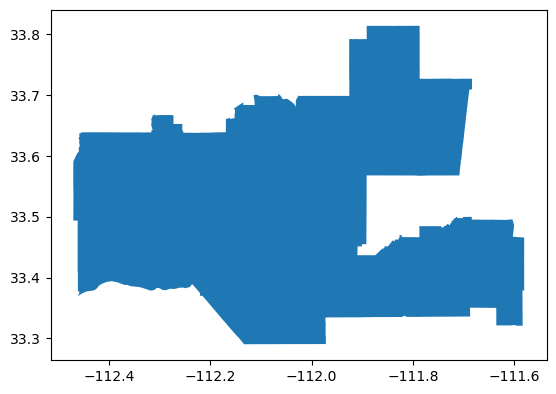

In [3]:
# Clean up Arizona data
arizona.columns = arizona.columns.str.lower()

# Select just the Phoenix area
phoenix = arizona[arizona.name == "Phoenix"]

# Generate a quick plot of the Phoenix shape
phoenix.plot()

When making maps it's important to know what Coordinate Reference System we are dealing with. Let's check what we have for the Phoenix file:

In [4]:
phoenix.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

Now that I have my Arizona data looking how I want it, lets access the Microsoft Planetary Computer!

In [5]:
# Access the MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

catalog.get_collections()
collections = list(catalog.get_collections())

# Print the number of collections
print('Number of collections:', len(collections))

#Pull out the Impact Observatory collection
io_collection = catalog.get_child('io-biodiversity')
io_collection

Number of collections: 125


<CollectionClient id=io-biodiversity>

Now that we have our data, we need to specify the temporal and spatial information we are interested in. I will create a bounding box, that specifies our spatial area of interest.

As we can see from the description of the Impact Observatory Collection above, the only dates represented in the data are our time range of interest (2017-2020). As such, there is no need to specify a temporal variable. 

In [6]:
# Create bounding box
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

In [7]:
# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox_of_interest)

# Get items from search
items = search.item_collection()

# Determine number of items in search
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


In [8]:
# Retrieve items
item_names = {item.id : item for item in search.items()}
list(item_names) # from this list, we can see that our 1st item is 2020 data, and our 4th item is 2017 data

# Select 2017 subset
phx_2017 = items[3]

# Select 2020 subset
phx_2020 = items[0]

Our search returned four STAC Items. We can tell from their IDs that that they contain data for the same area but for different times, specifically the years 2017 through 2020. Let's display the available assets and properties for the 2017 Item.

In [9]:
asset_table = rich.table.Table("Asset Key", "Asset Title")
for key, value in items[-1].assets.items():
    asset_table.add_row(key, value.title)
asset_table

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Asset Title                     ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data             │ Biodiversity Intactness         │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

In [10]:
property_table = rich.table.Table("Property Name", "Property Value")
for key, value in sorted(items[-1].properties.items()):
    property_table.add_row(key, str(value))
property_table

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Property Name  ┃ Property Value                                                                                 ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ datetime       │ None                                                                                           │
│ end_datetime   │ 2017-12-31T23:59:59Z                                                                           │
│ proj:epsg      │ 4326                                                                                           │
│ proj:shape     │ [7992, 7992]                                                                                   │
│ proj:transform │ [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215,                 │
│                │ 34.74464974521749, 0.0, 0.0, 1.0]                                                              │
│ start_datetime │ 2017-01-01T00:00:00Z                                                                           │
└────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

#### Let's look at a raster. 

We can see from the tables, that the Planetary Computer includes a "Rendered Preview". Let's take a look at the 2017 data:

In [11]:
# Plot rendered preview
Image(url=phx_2017.assets['rendered_preview'].href, width=500)

In [ ]:
# Take a loot at a single raster's info
#bio_2017 = rioxr.open_rasterio(item.assets['data'].href)
#bio_2017

In [ ]:
# Remove length 1 dimension (band)
#bio_2017 = bio_2017.squeeze().drop_vars('band')

## Visualization: Map of Phoenix County AZ 

In order to better visualize the Phoenix area, I will make a map, and add in a basemap using the Contextily package. This map will give us a good visual of the greater Phoenix area, and will better help us understand our biodiveristy analysis later.

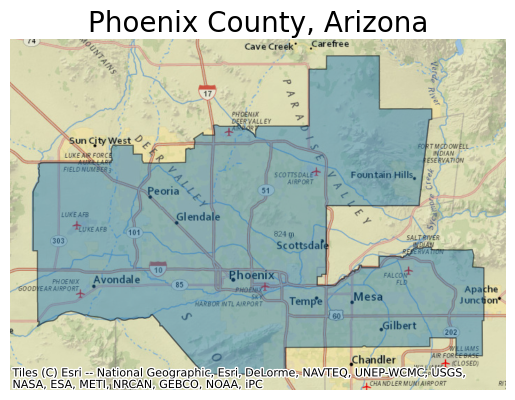

In [12]:
# set up figure
fig, ax = plt.subplots()

# create axis with plot
(phoenix.to_crs(epsg=3857) 
      .plot(ax=ax, figsize=(11, 10), alpha=0.45, edgecolor="k"))

# add NatGeo basemap from contextily
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix County, Arizona", fontdict= {"fontsize": "20"})
ax.set_axis_off()


## Biodiversity Intactness Index

Now that we have a good basemap, showing roads and ciites for context, we can work on also plotting our Plantary Computer data, to see biodiversity intactness in this highly urban area. 

Remembering the data tables created above, I know that I am interested the "data" asset, which should contain the information that I need to continue my comparative analysis. Since my analysis will involve directly comparing the years 2017 and 2020, I will create variables defining the assets of those years specifically. 

In [13]:
# Retrieve 2017 biodiversity data 
phx_2017_asset = phx_2017.assets["data"]
phx_2017_data = rioxr.open_rasterio(phx_2017_asset.href)

# Retrieve 2020 biodiversity data 
phx_2020_asset = phx_2020.assets["data"]
phx_2020_data = rioxr.open_rasterio(phx_2020_asset.href)

phx_2017_data
phx_2020_data

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Since there is only 1 band, we can remove that dimension for a more easily managed dataset.

In [14]:
phx_2017_data = phx_2017_data.squeeze().drop_vars('band')
phx_2020_data = phx_2020_data.squeeze().drop_vars('band')

Now, I need to clip the Planetary Computer data to match the Phoenix polygon I created earlier. I will make sure that my Coordinate Reference Systems match, before clipping and plotting.

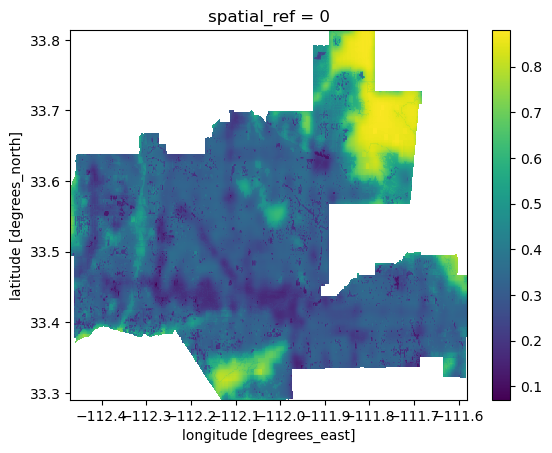

In [15]:
# Match CRSs
phoenix = phoenix.to_crs(phx_2017_data.rio.crs)

# Assert check to ensure it worked
assert phoenix.crs == phx_2017_data.rio.crs

# Clip 2017 BII raster to the Phoenix polygon
phx_clip_2017 = phx_2017_data.rio.clip(phoenix["geometry"])

# And again for 2020
phx_clip_2020 =  phx_2020_data.rio.clip(phoenix["geometry"])

# Let's see how that looks for 2017
phx_clip_2017.plot()

## Calculating the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020. 

In order to do this calculation, I need to do a bit of "map algebra".

1. I need to find the total number of pixels in the Phoenix subdivision polygon, for both years. 

2. Then, I need to find the numbers of pixels with the BII at 0.75 or higher, again for both years. 

3. Finally, I can use those pixel numbers I get to calculate the desired percentage.


In [18]:
# Calculate total area for 2017
total_2017 = phx_clip_2017.count().item() 
# Calculate total area for 2020
total_2020 = phx_clip_2020.count().item()

# Calculate BII % for 2017, Make the data binary for easy math
phx_bii_2017 = (phx_clip_2017 >= 0.75).astype(int)
pixels_2017 = phx_bii_2017.sum().item()

# Calculate BII % for 2020
phx_bii_2020 = (phx_clip_2020 >= 0.75).astype(int)
pixels_2020 = phx_bii_2020.sum().item()



# Calcualte the percentage area for 2017 data:
pct_bii_2017 =  (pixels_2017 / total_2017) * 100

# Calculate the percentage area for 2020 data:
pct_bii_2020 = (pixels_2020 / total_2020) * 100

# Print output
pct_text = "The percentage of area in Phoenix County with a BII over 0.75 in"
print(pct_text, "2017 is: ", round(pct_bii_2017, 2), "%")

print(pct_text, "2020 is: ", round(pct_bii_2020, 2), "%")

The percentage of area in Phoenix County with a BII over 0.75 in 2017 is:  7.13 %
The percentage of area in Phoenix County with a BII over 0.75 in 2020 is:  6.49 %


## Visualization: Biodiversity Loss

Now that we have calculated the differences in biodiversity density between the two years, we can visualize this difference with a map. 

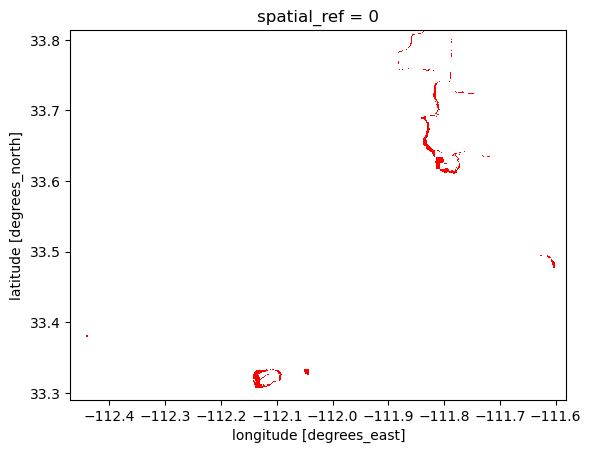

In [20]:
# Find areas where there was a loss in BII from 2017 to 2020
phx_bii_diff = phx_bii_2017 - phx_bii_2020

# Make a mask - like in 223!
phx_mask = phx_bii_diff == 1

# Convert to int type
phx_mask = phx_mask.astype(int)

# Make a color gradient
color_id = ["none", "red"]

# Make a color map object
cmap = plt.cm.colors.ListedColormap(color_id)

# Plot!
phx_mask.plot(cmap = cmap, add_colorbar = False)

Now that we have applied a color map visualization to our biodiversity loss, we can overlay this with our Planetary Computer raster, and our Phoenix subdivision polygon, to create a final visualization that shows us the area, in red, where Phoenix county experienced significant biodiversity losee. 

## Final Visualization:

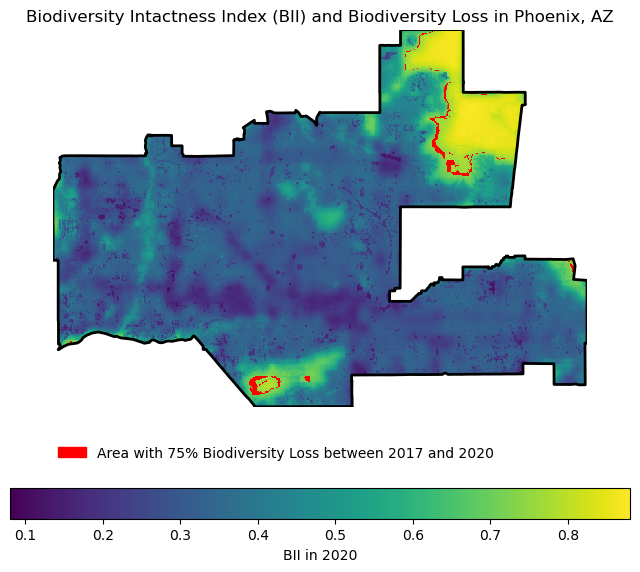

In [30]:
# Initialize plot
fig, ax = plt.subplots(figsize = (8, 7))

# Remove axes
ax.axis("off")

# Begin with clipped raster layer
phx_clip_2020.plot(ax = ax,
                  cbar_kwargs = {"location": "bottom",
                                "label": "BII in 2020"})
# Add mask layer
phx_mask.plot(ax = ax,
             cmap = cmap,
             add_colorbar = False)
phx_mask_patch = mpatches.Patch(color = "red",
                      label = "Area with 75% Biodiversity Loss between 2017 and 2020")
# Add polygon layer
phoenix.plot(ax = ax, 
            color = "none",
            edgecolor = "black",
            linewidth = 2)

# update legend, add in BII loss patch
ax.legend(handles = [phx_mask_patch],
          frameon = False,
          bbox_to_anchor = (0.85, -0.07))
ax.set_title("Biodiversity Intactness Index (BII) and Biodiversity Loss in Phoenix, AZ")

plt.show()

## Conclusion

Python and Jupyter Notebooks, as we can see, are powerful tools that allow us to conduct high level analyis with large amounts of spatial data.

In this analysis, we can use these tools to visualize the sharp decrease in biodiversity in this area, perhaps due to urbanization and human impact. Such an analysis can be used to further understand the overall biodiversity crisis, and can help inform decision makers about the needs and priorities of conservation efforts. 

### Citations:

C. Galaz García, EDS 220 - Working with Environmental Datasets, Course Notes. 2024. [Online]. Available: https://meds-eds-220.github.io/MEDS-eds-220-course/book/preface.html

Microsoft Planetary Computer, STAC Catalog. Biodiversity Intactness ('io-biodiversity'). [Dataset]. https://planetarycomputer.microsoft.com/dataset/io-biodiversity Accessed 2 December 2024.

United States Census Bureau. (2022). Arizona County Subdivision 2022 TIGER/Line Shapefiles. [Data File]. U.S. Census Bureau, Geography Division. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions Accessed 2 December 2024.


